In [20]:
greetings = "Assalam-o-Alaikum!"
print(greetings)

Assalam-o-Alaikum!


### Import Libraries

In [34]:
import pandas as pd
import re

import nltk
nltk.download('punkt')

from scipy.cluster.vq import vq, kmeans, whiten
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sarma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Document Clustering

In [22]:
df = pd.read_csv("movies_plot.csv")
df[:3]

,Title,Plot
0,The Ballad of Cable Hogue,"Cable Hogue is isolated in the desert, awaitin..."
1,Monsters vs. Aliens,"In the far reaches of space, a planet explodes..."
2,The Bandit Queen,Zarra Montalvo is the daughter of an American ...


In [23]:
def remove_noise(text, stop_words = []):
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        token = re.sub('[^A-Za-z0-9]+', '', token)
        if len(token) > 1 and token.lower() not in stop_words:
            # Get lowercase
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [26]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.75, max_features=50, tokenizer=remove_noise)

# Use the .fit_transform() on the list plots
tfidf_matrix = tfidf_vectorizer.fit_transform(df["Plot"])

In [31]:
num_clusters = 2

# Generate cluster centers through the kmeans function
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

# Generate terms from the tfidf_vectorizer object
terms = tfidf_vectorizer.get_feature_names()

for i in range(num_clusters):
    # Sort the terms and print top 3 terms
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:3])

['her', 'she', 'him']
['him', 'they', 'who']


### Import Fifa Dataset

In [32]:
fifa = pd.read_csv('fifa_18_sample_data.csv')
fifa.head()

,ID,name,full_name,club,club_logo,special,age,league,birth_date,height_cm,...,prefers_cb,prefers_lb,prefers_lwb,prefers_ls,prefers_lf,prefers_lam,prefers_lcm,prefers_ldm,prefers_lcb,prefers_gk
0,20801,Cristiano Ronaldo,C. Ronaldo dos Santos Aveiro,Real Madrid CF,https://cdn.sofifa.org/18/teams/243.png,2228,32,Spanish Primera División,1985-02-05,185.0,...,False,False,False,False,False,False,False,False,False,False
1,158023,L. Messi,Lionel Messi,FC Barcelona,https://cdn.sofifa.org/18/teams/241.png,2158,30,Spanish Primera División,1987-06-24,170.0,...,False,False,False,False,False,False,False,False,False,False
2,190871,Neymar,Neymar da Silva Santos Jr.,Paris Saint-Germain,https://cdn.sofifa.org/18/teams/73.png,2100,25,French Ligue 1,1992-02-05,175.0,...,False,False,False,False,False,False,False,False,False,False
3,176580,L. Suárez,Luis Suárez,FC Barcelona,https://cdn.sofifa.org/18/teams/241.png,2291,30,Spanish Primera División,1987-01-24,182.0,...,False,False,False,False,False,False,False,False,False,False
4,167495,M. Neuer,Manuel Neuer,FC Bayern Munich,https://cdn.sofifa.org/18/teams/21.png,1493,31,German Bundesliga,1986-03-27,193.0,...,False,False,False,False,False,False,False,False,False,True


In [35]:
fifa['scaled_pac'] = whiten(fifa['pac'])
fifa['scaled_dri'] = whiten(fifa['dri'])
fifa['scaled_sho'] = whiten(fifa['sho'])

In [36]:
cluster_centers, _ = kmeans(fifa[['scaled_pac', 'scaled_dri', 'scaled_sho']], 3)

fifa['cluster_labels'], _ = vq(fifa[['scaled_pac', 'scaled_dri', 'scaled_sho']], cluster_centers)

In [37]:
# Print the size of the clusters
print(fifa.groupby('cluster_labels')['ID'].count())

cluster_labels
0    182
1    456
2    362
Name: ID, dtype: int64


In [38]:
# Print the mean value of wages in each cluster
print(fifa.groupby('cluster_labels')['eur_wage'].mean())

cluster_labels
0    63225.274725
1    77050.438596
2    62955.801105
Name: eur_wage, dtype: float64


**The overall level of a player in FIFA 18 is defined by six characteristics: pace (pac), shooting (sho), passing (pas), dribbling (dri), defending (def), physical (phy)**

In [39]:
fifa['scaled_def'] = whiten(fifa['def'])
fifa['scaled_phy'] = whiten(fifa['phy'])

In [40]:
scaled_features = ['scaled_pac', 'scaled_sho', 'scaled_pac', 'scaled_dri', 'scaled_def', 'scaled_phy']

                scaled_pac  scaled_sho  scaled_pac  scaled_dri  scaled_def  \
cluster_labels                                                               
0                 6.823241    5.467249    6.823241    8.571332    2.385568   
1                 5.466300    3.975877    5.466300    7.036284    3.861597   

                scaled_phy  
cluster_labels              
0                 8.285080  
1                 9.112066  
0 ['Cristiano Ronaldo' 'L. Messi' 'Neymar' 'L. Suárez' 'M. Neuer']
1 ['T. Kroos' 'Sergio Ramos' 'G. Chiellini' 'L. Bonucci' 'J. Boateng']


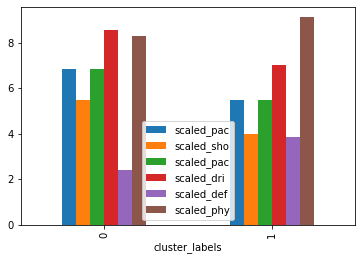

In [41]:
# Create centroids with kmeans for 2 clusters
cluster_centers, _ = kmeans(fifa[scaled_features], 2)

# Assign cluster labels and print cluster centers
fifa['cluster_labels'], _ = vq(fifa[scaled_features], cluster_centers)
print(fifa.groupby('cluster_labels')[scaled_features].mean())

# Plot cluster centers to visualize clusters
fifa.groupby('cluster_labels')[scaled_features].mean().plot(legend=True, kind='bar')

# Get the name column of first 5 players in each cluster
for cluster in fifa['cluster_labels'].unique():
    print(cluster, fifa[fifa['cluster_labels'] == cluster]['name'].values[:5])